In [ ]:
! pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.3 MB/s eta 0:00:00


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import darts
import statsmodels
import statsmodels.api as sm


import math
from typing import List, Optional, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelmax
from scipy.stats import norm
from statsmodels.compat.python import lzip
from statsmodels.tsa.seasonal import MSTL, STL, seasonal_decompose
from statsmodels.tsa.stattools import (
    acf,
    adfuller,
    ccovf,
    grangercausalitytests,
    kpss,
    pacf,
)
from darts import TimeSeries
from darts.dataprocessing.transformers import Diff
from darts.logging import get_logger, raise_if, raise_if_not, raise_log
from darts.utils.missing_values import fill_missing_values
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.utils.statistics import check_seasonality, plot_pacf, plot_acf, stationarity_test_adf

logger = get_logger(__name__)

# PART - 1 (SARIMA)

In [134]:
pharma_drug_sale_df = pd.read_csv("/content/PharmaDrugSales_1.csv")

In [135]:
pharma_drug_sale_df.head(2)

,Month,Sales
0,7/1/1991,3.526591
1,8/1/1991,3.180891


In [136]:
from datetime import datetime
datetime_obj = pharma_drug_sale_df.Month.apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
pharma_drug_sale_df["datetime_obj"] = datetime_obj

In [137]:
pharma_drug_sale_df.tail()

,Month,Sales,datetime_obj
199,2/1/2008,21.654285,2008-02-01
200,3/1/2008,18.264945,2008-03-01
201,4/1/2008,23.107677,2008-04-01
202,5/1/2008,22.912510,2008-05-01
203,6/1/2008,19.431740,2008-06-01


In [138]:
pharma_drug_sale_df = pharma_drug_sale_df.reindex(columns = ("Month", "datetime_obj", "Sales"))

In [139]:
# Conversion performed by the package on the data
darts_converted_original_data = TimeSeries.from_dataframe(df = pharma_drug_sale_df, value_cols= "Sales", time_col = "datetime_obj")
darts_converted_original_data.head()

<TimeSeries (DataArray) (datetime_obj: 5, component: 1, sample: 1)> Size: 40B
array([[[3.526591]],

       [[3.180891]],

       [[3.252221]],

       [[3.611003]],

       [[3.565869]]])
Coordinates:
  * datetime_obj  (datetime_obj) datetime64[ns] 40B 1991-07-01 ... 1991-11-01
  * component     (component) object 8B 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Timeseries plot & ACF

**Plotting Lags in ACF: Recommended = (Datapoints / 4). Increasing the lags in plot to see overall phenomenon. Moreover, using Darts package that handles timeseries data to supplement the analysis.**

**Based on the timeseries plot, ACF plot, the seasonal period come at a lag of 12, i.e., after every 12 months. The multiplicative seasonal time period in our dataset is occuring around December/January of each year.**

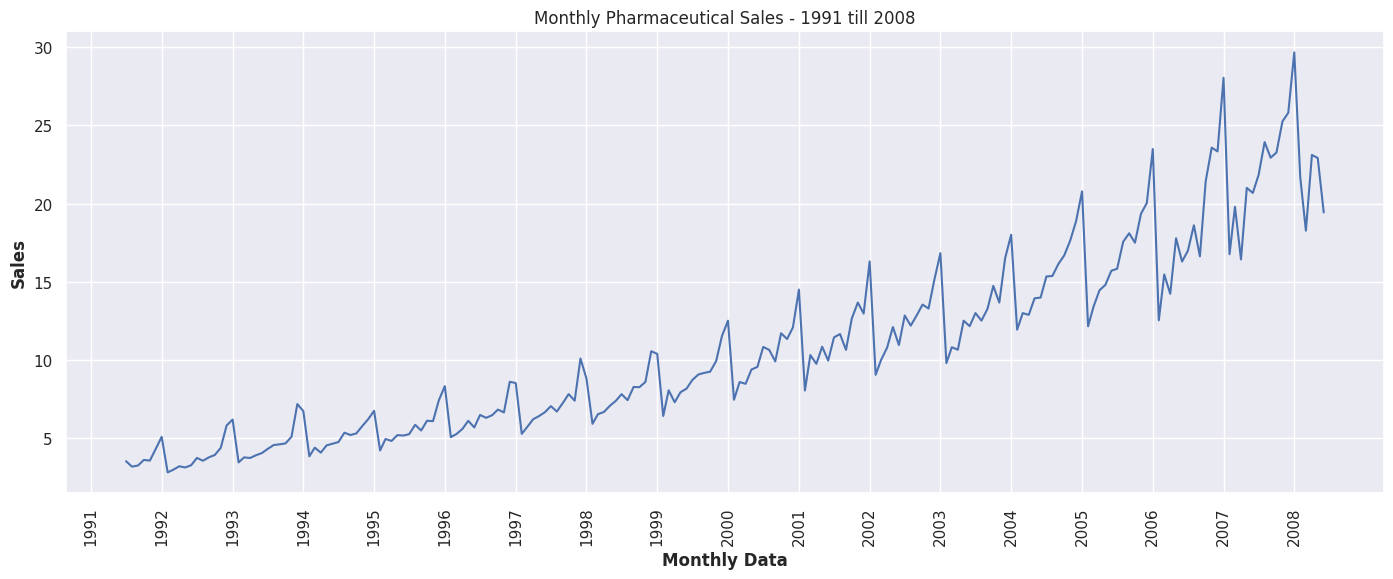

In [140]:
# TimeSeries Plot
plt.figure(figsize = (17, 6))
sns.set_theme(style="darkgrid")
sns.lineplot(x='datetime_obj', y='Sales', data=pharma_drug_sale_df)
plt.xlabel("Monthly Data")
plt.xticks(rotation=90)
plt.ylabel("Sales")



years = pharma_drug_sale_df['datetime_obj'].dt.year.unique()
year_starts = [datetime(year, 1, 1) for year in years]

plt.title("Monthly Pharmaceutical Sales - 1991 till 2008")
plt.xticks(year_starts, [str(year) for year in years], rotation=90)

plt.show()

In [141]:
# Seasonal Period is a lag 12 based on the standard error computed using the Bartlett formula
check_seasonality(darts_converted_original_data, m = 12)

(True, 12)

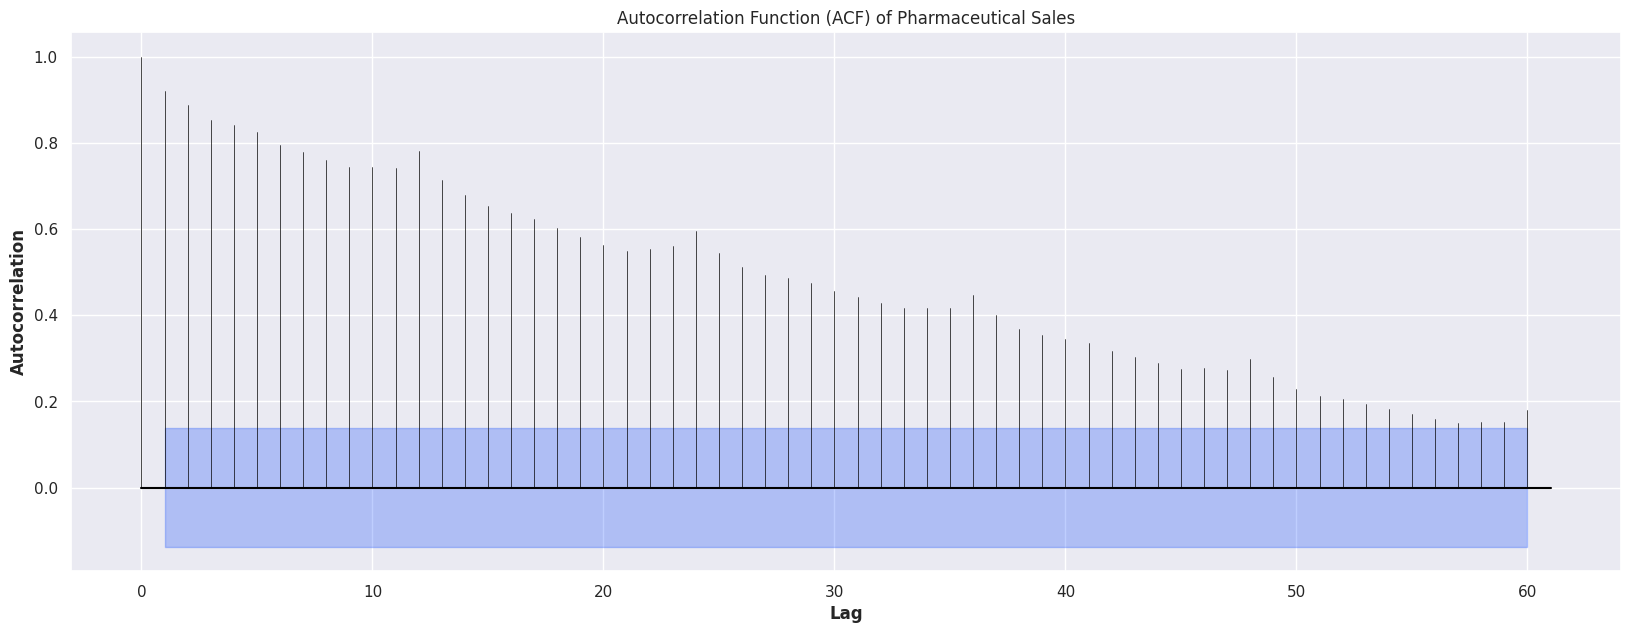

In [142]:
# ACF raw data
plot_acf(darts_converted_original_data, max_lag=60, alpha=0.05, fig_size = (20,7), bartlett_confint=False)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function (ACF) of Pharmaceutical Sales")
plt.show()

## Moving Average Window

**Computing the Moving Average Window length of 12 datapoints to coincide with the seasonal period.**

**Observing the smoothed time series it is apparent that there is an increasing trend.**

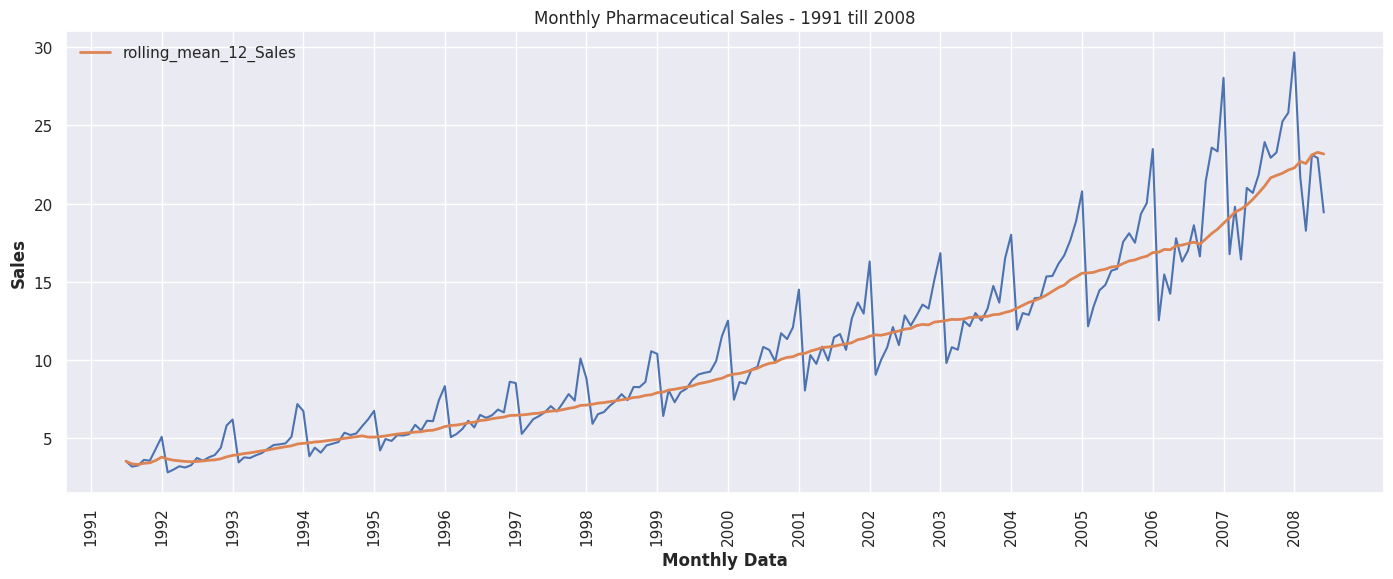

In [109]:
years = pharma_drug_sale_df['datetime_obj'].dt.year.unique()
year_starts = [datetime(year, 1, 1) for year in years]

# Create a MovingAverageFilter object with Lag of 12
moving_average_filter = MovingAverageFilter(window=12, centered=False)
filtered_data = moving_average_filter.filter(darts_converted_original_data)


# TimeSeries Plot
plt.figure(figsize = (17, 6))
sns.set_theme(style="darkgrid")
sns.lineplot(x='datetime_obj', y='Sales', data=pharma_drug_sale_df)

# Moving average line plot
filtered_data.plot()

plt.title("Monthly Pharmaceutical Sales - 1991 till 2008")
plt.xlabel("Monthly Data")
plt.ylabel("Sales")
plt.xticks(year_starts, [str(year) for year in years], rotation=90)
plt.show()

## First order differencing


In [143]:
# First Order Differencing
first_order_differencing = Diff(lags=1, dropna=True).fit_transform(darts_converted_original_data)

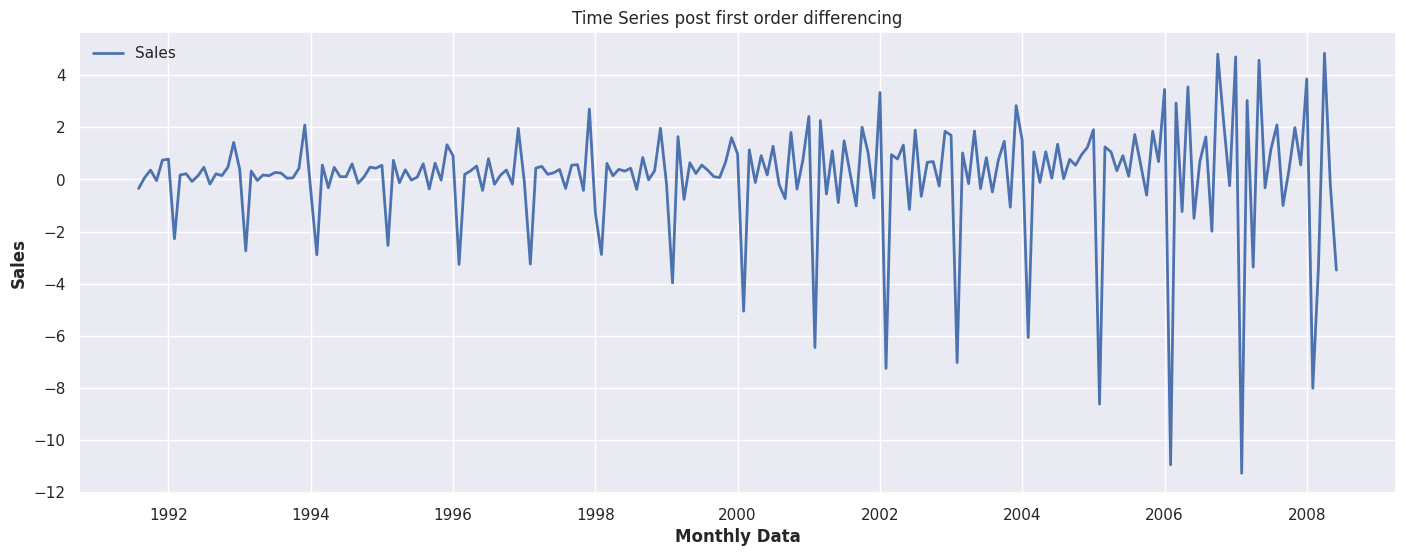

In [144]:
# Timeseries post differencing
plt.figure(figsize = (17, 6))
TimeSeries.plot(first_order_differencing, label = '')
plt.title("Time Series post first order differencing")
plt.xlabel("Monthly Data")
plt.ylabel("Sales")
plt.show()

**As the first order differencing (aka detrending) has removed the component of the trend from the time series data, the ACF is no longer tapering off slowly, which is a typical behaviour if a trend was present. Now, with only seasonality and noise present, only the data points at lags 12 i.e., the seasonal period are auto-correlated**.

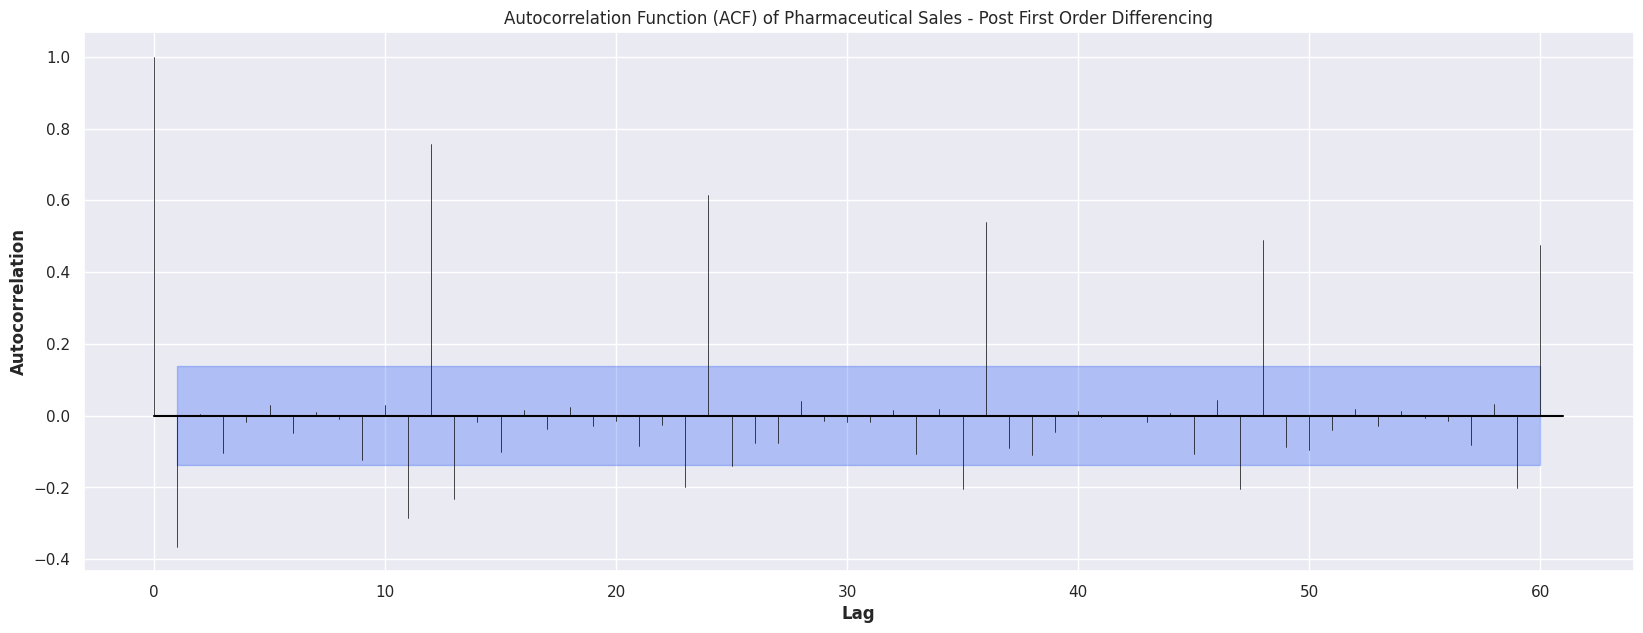

In [145]:
# ACF First Order Differencing
plot_acf(first_order_differencing, max_lag=60, alpha=0.05, fig_size = (20,7), bartlett_confint=False)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function (ACF) of Pharmaceutical Sales - Post First Order Differencing")
plt.show()

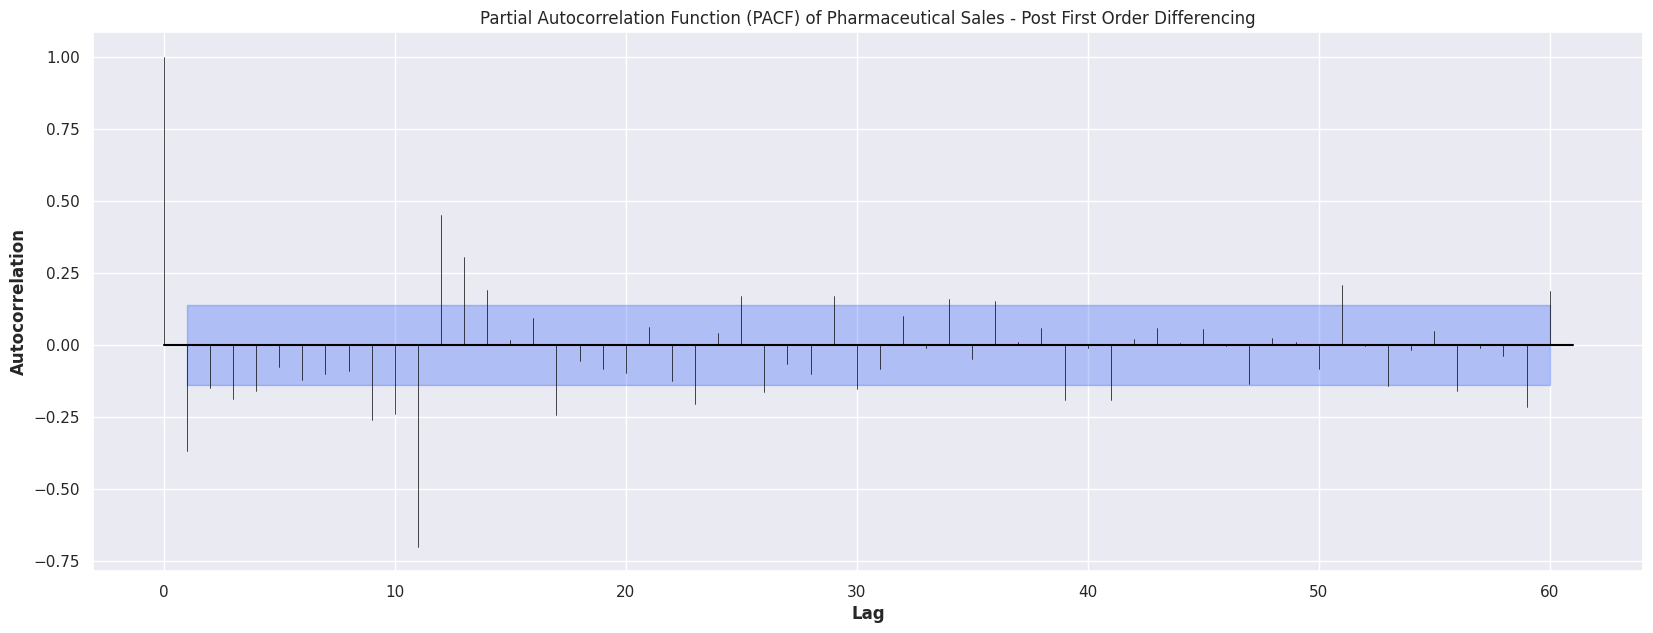

In [146]:
# PACF post first order differencing
plot_pacf(first_order_differencing, max_lag=60, alpha=0.05, fig_size = (20,7))
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Partial Autocorrelation Function (PACF) of Pharmaceutical Sales - Post First Order Differencing")
plt.show()

## Differencing - Seasonality

In [147]:
# Differencing at lag 12
differencing_on_seasonality = Diff(lags=12, dropna=True).fit_transform(first_order_differencing)

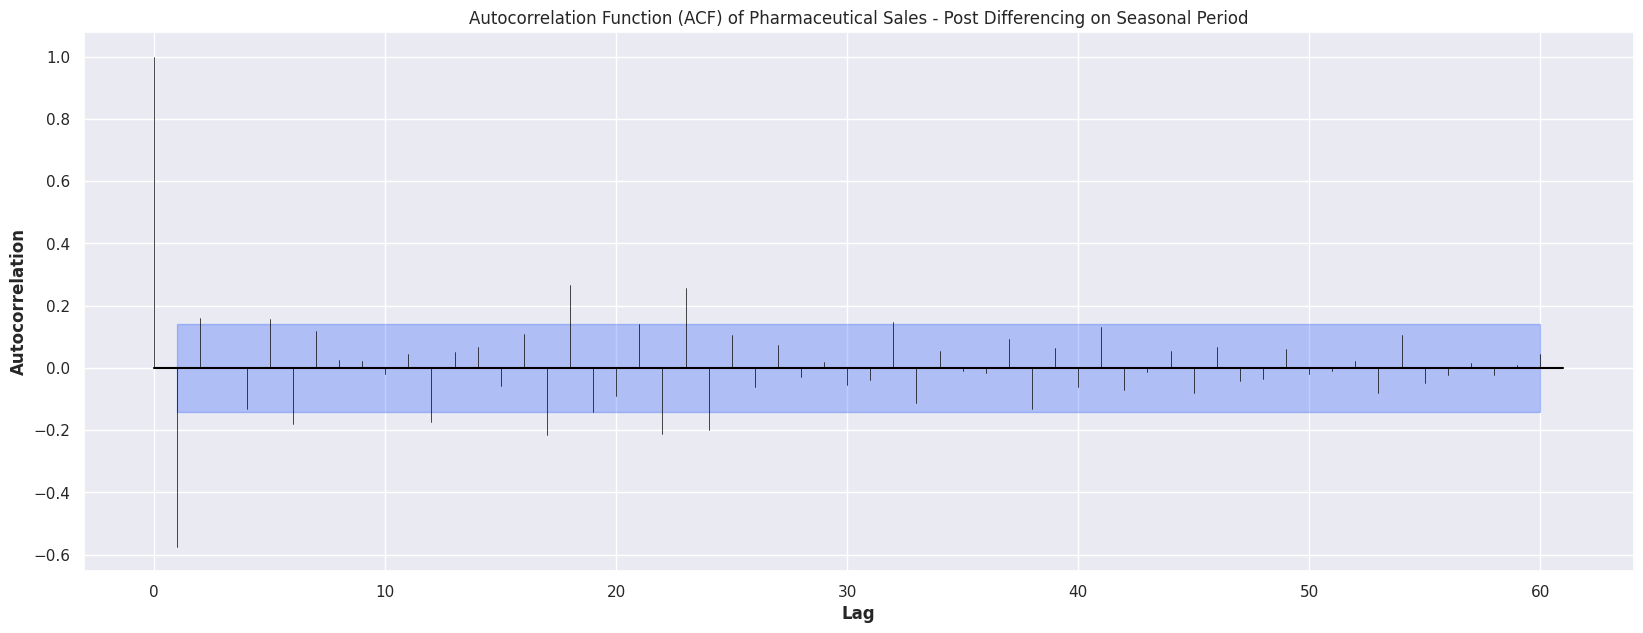

In [148]:
# ACF plot post seasonal differencing
plot_acf(differencing_on_seasonality, max_lag=60, alpha=0.05, fig_size = (20,7), bartlett_confint=False)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function (ACF) of Pharmaceutical Sales - Post Differencing on Seasonal Period")
plt.show()

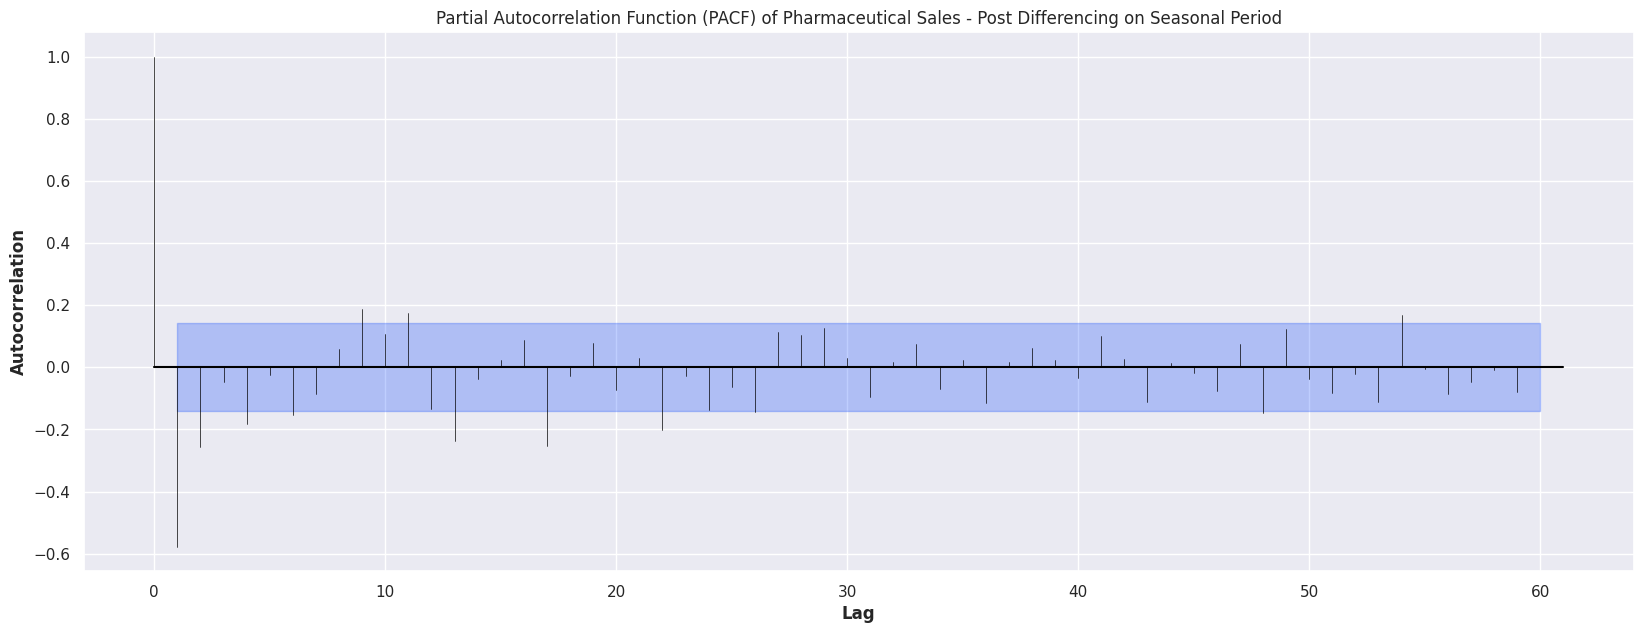

In [149]:
# PACF plot post seasonal differencing
plot_pacf(differencing_on_seasonality, max_lag=60, alpha=0.05, fig_size = (20,7))
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Partial Autocorrelation Function (PACF) of Pharmaceutical Sales - Post Differencing on Seasonal Period")
plt.show()

## Modelling - SARIMA

In [150]:
original_till_june_05, original_after_june_05 = darts_converted_original_data.split_after(pd.Timestamp("2005-06-01")) # %Y-%m-%d

# Till June 2005
print(f"Training data - LAST timestamp: {original_till_june_05.end_time()}")

# Post June 2005
print(f"Test data - FIRST timestamp: {original_after_june_05.start_time()}")

Training data - LAST timestamp: 2005-06-01 00:00:00
Test data - FIRST timestamp: 2005-07-01 00:00:00


In [ ]:
# Checking combination of (p,q,P,Q) - MIN VALUE = 0, MAX threshold = 3

import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
import warnings
warnings.filterwarnings("ignore")

i = 0
corresponding_parameter = []
aic_values = []
run_no = []

for p,q,P,Q in list(itertools.product(range(0,4), repeat=4)):
  try:
    sarimax_model_manual_1 = SARIMAX(original_till_june_05.values().squeeze(), order = (p,1,q), seasonal_order = (P,1,Q,12))
    result_1 = sarimax_model_manual_1.fit()
    corresponding_parameter.append((p,q,P,Q))
    aic_values.append(round(result_1.aic,4))
  except:
    # print(f"RUN #:{i}  \n Convergence failed for Paramaters p:{p},q:{q},P:{P},Q:{Q}")
    continue

  i += 1
  run_no.append(i)
  if i % 20 == 0:
    print(f"RUN TILL NOW: {i} and  RUNS REMAINING: {((4 ** 4) - i)}    \n Paramaters p:{p},q:{q},P:{P},Q:{Q} ---  AIC : {round(result_1.aic,4)}")

RUN TILL NOW: 20 and  RUNS REMAINING: 236    
 Paramaters p:0,q:1,P:0,Q:3 ---  AIC : 277.0766
RUN TILL NOW: 40 and  RUNS REMAINING: 216    
 Paramaters p:0,q:2,P:1,Q:3 ---  AIC : 273.702
RUN TILL NOW: 60 and  RUNS REMAINING: 196    
 Paramaters p:0,q:3,P:2,Q:3 ---  AIC : 275.3711
RUN TILL NOW: 80 and  RUNS REMAINING: 176    
 Paramaters p:1,q:1,P:0,Q:0 ---  AIC : 286.0335
RUN TILL NOW: 100 and  RUNS REMAINING: 156    
 Paramaters p:1,q:2,P:1,Q:0 ---  AIC : 281.4044
RUN TILL NOW: 120 and  RUNS REMAINING: 136    
 Paramaters p:1,q:3,P:2,Q:0 ---  AIC : 280.3454
RUN TILL NOW: 140 and  RUNS REMAINING: 116    
 Paramaters p:2,q:0,P:3,Q:0 ---  AIC : 280.3782
RUN TILL NOW: 160 and  RUNS REMAINING: 96    
 Paramaters p:2,q:2,P:0,Q:0 ---  AIC : 288.7539
RUN TILL NOW: 180 and  RUNS REMAINING: 76    
 Paramaters p:2,q:3,P:1,Q:0 ---  AIC : 278.6336
RUN TILL NOW: 200 and  RUNS REMAINING: 56    
 Paramaters p:3,q:0,P:2,Q:0 ---  AIC : 281.0704
RUN TILL NOW: 220 and  RUNS REMAINING: 36    
 Paramaters 

In [ ]:
# Dataframe of all Hyperparameters andrespective AICs
AICs_SARIMA_df = pd.concat([pd.Series(run_no, name = "RUN_NO"), pd.Series(corresponding_parameter, name= "Parameters: (p,q,P,Q)"), pd.Series(aic_values, name = "AIC_Values")], axis = 1)
AICs_SARIMA_df_sorted = AICs_SARIMA_df.sort_values(by = "AIC_Values", ascending = True).copy()
AICs_SARIMA_df_sorted.head(5)

,RUN_NO,"Parameters: (p,q,P,Q)",AIC_Values
214,215,"(3, 1, 1, 3)",270.9511
246,247,"(3, 3, 1, 3)",271.4544
230,231,"(3, 2, 1, 3)",272.2226
240,241,"(3, 3, 0, 1)",272.5804
247,248,"(3, 3, 2, 0)",272.9494


In [ ]:
# AUTOMATED ARIMA FOR VERIFICAION...
import pmdarima as pm
sarima_model_auto_cp = pm.auto_arima(original_till_june_05.values().squeeze(),
                             start_p=0, start_q=0,start_P=0, start_Q = 0, max_p= 3 , max_q= 3 , max_P= 3, max_Q = 3, d = 1, D = 1,
                             seasonal=True, # Set to True for seasonal data
                             m=12, # Seasonal period (e.g., 12 for monthly data)
                             trace=True, # Print the progress of the search
                             #error_action='ignore', # Ignore warnings
                             suppress_warnings=True,
                             n_jobs = 1,
                             information_criterion='aic',
                             stepwise = False, # Checks all combinations of data
                             max_order=None) # Searches from minumum hyperparameter till max

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=357.532, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=354.752, Time=0.17 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=348.551, Time=0.61 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=350.530, Time=1.21 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=357.174, Time=0.14 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=351.467, Time=0.32 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=350.536, Time=1.02 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=10.50 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=350.922, Time=0.25 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=349.847, Time=0.75 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=4.16 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=10.17 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=350.439, Time=0.60 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=351.425, Time=1.53 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=inf, Time=8.63 sec
 ARIMA(0,1,0)(3,1,3)[12]

**Final Hyperparamaters Selected**

*p = 3, d = 1, q = 1*

*P = 1, D = 1, Q = 3, m = 12*

They provide the lowest AIC on the training data i.e., **270.951**.

In [151]:
# SARIMA Model with optimal hyperparameters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
sarimax_model_final = SARIMAX(original_till_june_05.values().squeeze(), order = (3,1,1), seasonal_order = (1,1,3,12))
sarimax_result_fit = sarimax_model_final.fit()
round(sarimax_result_fit.aic,3)

270.951

In [152]:
print(sarimax_result_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  168
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -126.476
Date:                                    Sun, 27 Oct 2024   AIC                            270.951
Time:                                            00:06:41   BIC                            298.342
Sample:                                                 0   HQIC                           282.077
                                                    - 168                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0680      0.091      0.747      0

## Predictions

**The model has generally understood the pattern of the original timeseries data, both in terms of the increasing trend and multiplicative seasonality. But it is not able to anticipate sudden in those time steps where there are sudden spikes and in those circumstances the model underestimates. The Mean Squared Error of 6.016 or the Root of MSE (RMSE) is 2.449, meaning on average the sale predictions will be off by 2.449 units.**

In [158]:
# MSE for test data
from sklearn.metrics import mean_squared_error
actual_original_values_after_june_05 = original_after_june_05.values().squeeze()
prediction_after_june_05 =  sarimax_result_fit.forecast(36)
print(f"forecasted values {prediction_after_june_05}\n\n")
print(f"MSE with chosen hyperparameter: {mean_squared_error(actual_original_values_after_june_05, prediction_after_june_05)}")

forecasted values [16.74595771 16.61945957 17.25535992 18.10764102 18.72239806 19.88578482
 22.21670545 13.5443948  14.97235223 15.59345646 16.56212115 16.82859805
 18.14544454 17.86047598 18.39357437 19.62918468 19.86557118 21.18497788
 23.81266864 15.07124414 16.53093963 16.96547149 18.200894   18.20409598
 19.7360232  19.41349285 20.01426263 21.29499668 21.57105616 22.86740213
 25.70966204 16.44062233 17.9013526  18.45431309 19.67909016 19.77606047]


MSE with chosen hyperparameter: 6.015753043186633


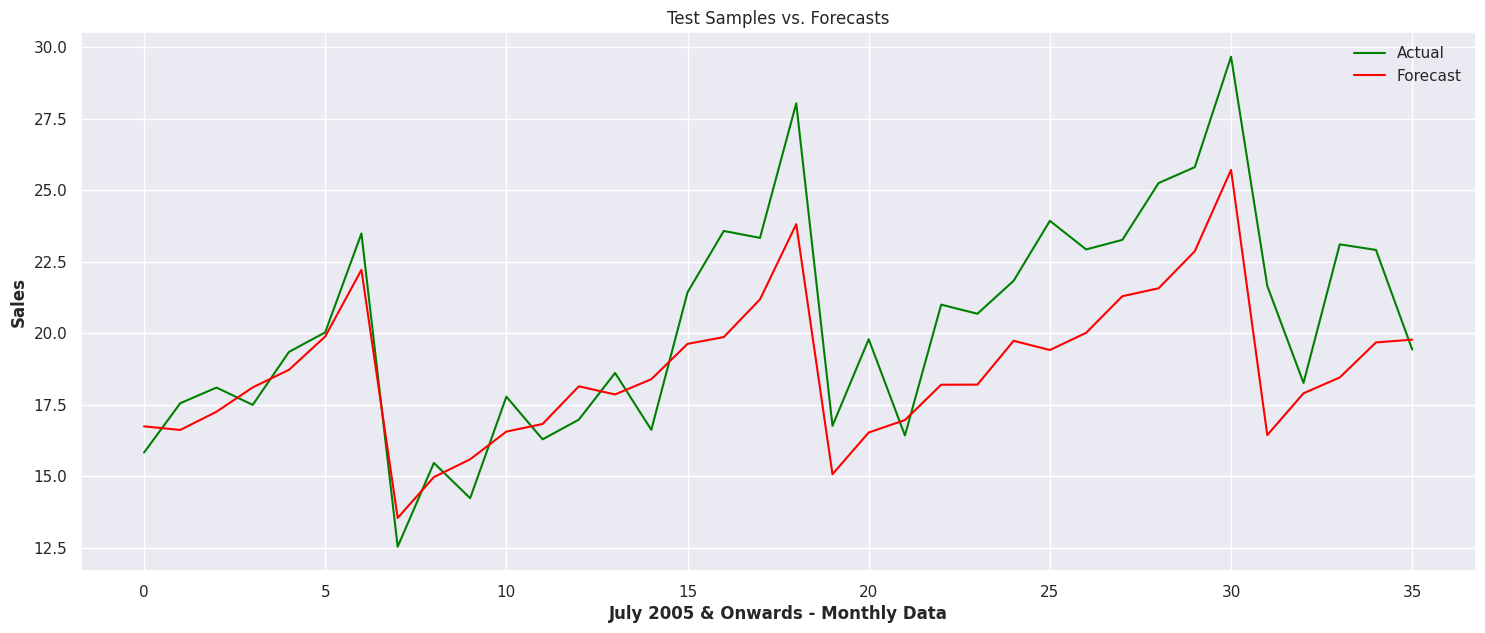

In [ ]:
plt.figure(figsize=(18,7))
sns.set_theme(style="darkgrid")
sns.lineplot(actual_original_values_after_june_05, color = 'green', label = "Actual")
sns.lineplot(prediction_after_june_05, color = 'red', label = "Forecast")
plt.title('Test Samples vs. Forecasts')
plt.ylabel("Sales")
plt.xlabel("July 2005 & Onwards - Monthly Data")
plt.legend()
plt.show()

# PART - 2 (AR)

**Total observations = 51 quarters**

In [38]:
wine_data_df = pd.read_csv("/content/TotalWine.csv")
wine_data_darts_df = TimeSeries.from_dataframe(df = wine_data_df, value_cols= "TotalWine", time_col = "Time (Quarter)")
print(wine_data_df.info(), "\n\n")
wine_data_darts_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Time (Quarter)  51 non-null     int64  
 1   TotalWine       51 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 944.0 bytes
None 




<TimeSeries (DataArray) (Time (Quarter): 5, component: 1, sample: 1)> Size: 40B
array([[[1.486]],

       [[1.915]],

       [[1.844]],

       [[2.808]],

       [[1.287]]])
Coordinates:
  * Time (Quarter)  (Time (Quarter)) int64 40B 1 2 3 4 5
  * component       (component) object 8B 'TotalWine'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

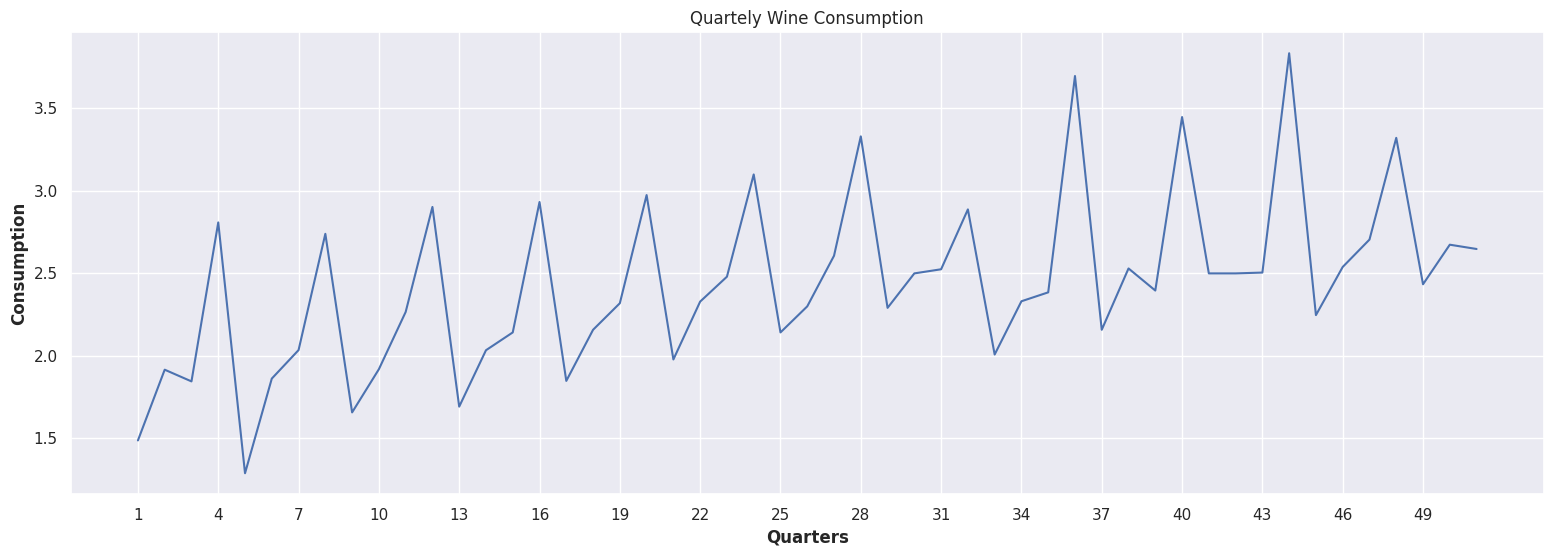

In [39]:
plt.figure(figsize=(19,6))
sns.set_theme(style="darkgrid")
sns.lineplot(wine_data_df, x = "Time (Quarter)", y = "TotalWine")
plt.title('Quartely Wine Consumption')
plt.ylabel("Consumption")
plt.xlabel("Quarters")
plt.xticks(wine_data_df["Time (Quarter)"][::3])
plt.show()

## Seasonal Differencing

In [40]:
# Checking seasonality based on multiple periods by utilizing standard error computed using the Bartlett formula
for i in (range(2,7)):
    print(f"{check_seasonality(wine_data_darts_df, m = i)}")

(True, 2)
(False, 3)
(True, 4)
(False, 5)
(False, 0)


In [41]:
# Differencing at multiple potential seasonal lags
differencing_on_seasonality_6_wine_data = Diff(lags=6, dropna=False).fit_transform(wine_data_darts_df)
differencing_on_seasonality_4_wine_data = Diff(lags=4, dropna=False).fit_transform(wine_data_darts_df)
differencing_on_seasonality_2_wine_data = Diff(lags=2, dropna=False).fit_transform(wine_data_darts_df)
differencing_on_seasonality_1_wine_data = Diff(lags=1, dropna=False).fit_transform(wine_data_darts_df)

**Based on the statistical test in dart package and plots post seasonal differencing, the most suitable differencing will be at lag 4. Meaning, that seasonality is occuring every fourth quarter, most likely in the holiday periods in month of December.**

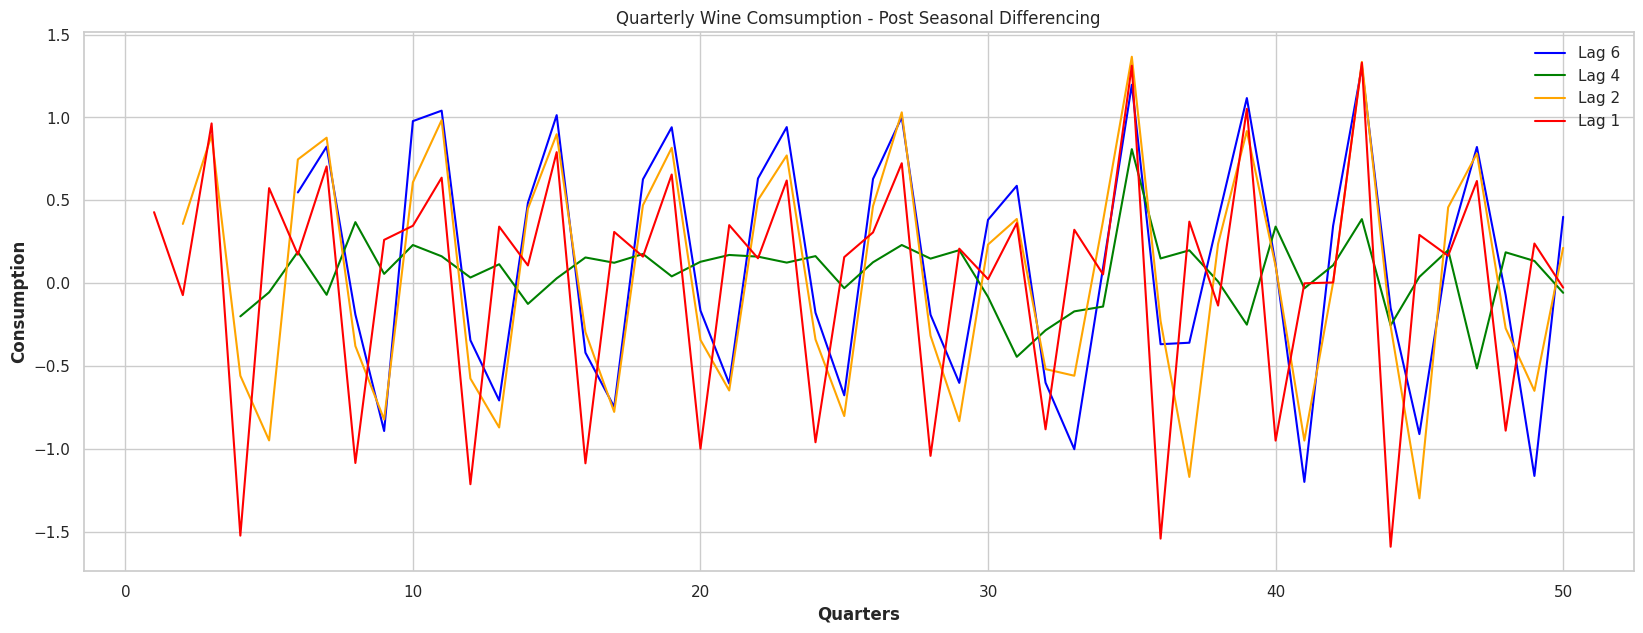

In [42]:
# Plots for data deseasonalised at different lags
plt.figure(figsize=(20,7))
sns.set_theme(style="whitegrid")
sns.lineplot(differencing_on_seasonality_6_wine_data.values().squeeze(), color = 'blue', label = "Lag 6")
sns.lineplot(differencing_on_seasonality_4_wine_data.values().squeeze(), color = 'green', label = "Lag 4")
sns.lineplot(differencing_on_seasonality_2_wine_data.values().squeeze(), color = 'orange', label = "Lag 2")
sns.lineplot(differencing_on_seasonality_1_wine_data.values().squeeze(), color = 'red', label = "Lag 1")
plt.title('Quarterly Wine Comsumption - Post Seasonal Differencing')
plt.ylabel("Consumption")
plt.xlabel("Quarters")
plt.legend()
plt.show()

**The ACF also supplements the initial analysis that the seasonal period occurs at lag of 4 i.e., at every 4th quarter.**

**Moreover, based on the ACF the component of trend is missing from the timeseries**

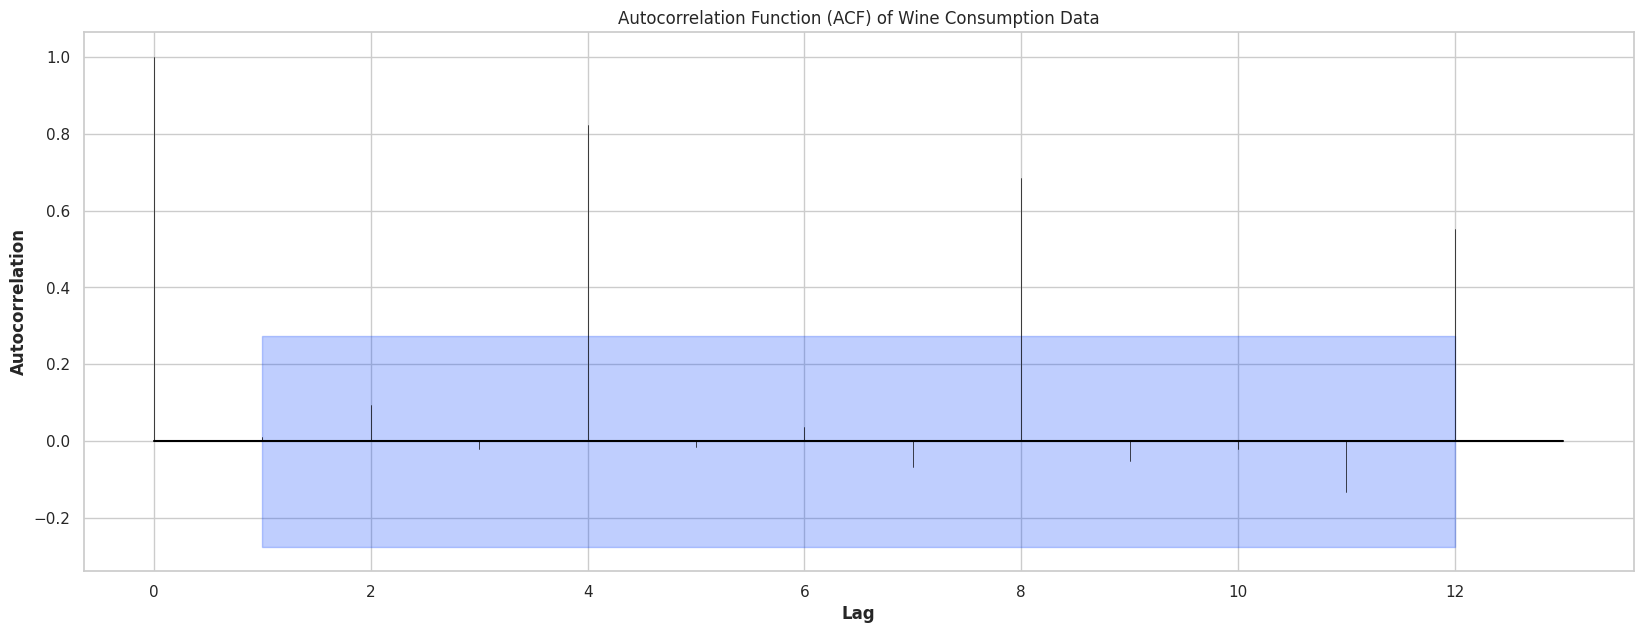

In [43]:
# ACF raw data. Using lags 51/4
plot_acf(wine_data_darts_df, max_lag=12, alpha=0.05, fig_size = (20,7), bartlett_confint=False)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function (ACF) of Wine Consumption Data")
plt.show()

## Model Order Selection

In [44]:
from statsmodels.tsa import ar_model

In [62]:
differencing_on_seasonality_4_wine_data_na_dropped = Diff(lags=4, dropna=True).fit_transform(wine_data_darts_df)

**Augmented Dickey Fuller - Test for Stationarity**

**ADF p-value of << 0.001 confirms that data is stationarity. Helps fulfill the requirement of the AR model.**

Returns:

. test statistic

. pvalues

. degrees of freedom

. OLS estimation results for the restricted model, the unrestricted model and the restriction (contrast) matrix for the parameter f_test

In [47]:
stationarity_test_adf(differencing_on_seasonality_4_wine_data_na_dropped, autolag = 'AIC')

(-6.488932083532099,
 1.2406014979609561e-08,
 3,
 43,
 {'1%': -3.5925042342183704,
  '5%': -2.931549768951162,
  '10%': -2.60406594375338},
 -12.997403271506357)

**Best Model Order is using lag 4 on the seasonality differenced data**

In [48]:
# AR Model lag selection on deseasonalized data
ar_model_select_order = ar_model.ar_select_order(differencing_on_seasonality_4_wine_data_na_dropped.values().squeeze(), ic = 'aic', maxlag = 10) # seasonal = True, period = 4)
ar_model_select_order.ar_lags

[1, 2, 3, 4]

In [49]:
# Additional Check
aic = []
model_order = []

for i in range(1,11):
  model = ar_model.AutoReg(differencing_on_seasonality_4_wine_data_na_dropped.values().squeeze(), lags=i, old_names=False) # seasonal = True, period = 4)
  result = model.fit()
  aic.append(result.aic)
  model_order.append(i)
  i += 1

ar_model_order_aics = pd.concat((pd.Series(aic, name = "AIC"), pd.Series(model_order, name = "model_order")), axis = 1)
ar_model_order_aics.sort_values(by = "AIC", inplace = True)
ar_model_order_aics

,AIC,model_order
3,-18.571191,4
4,-16.137238,5
6,-14.197955,7
5,-13.649083,6
7,-11.229618,8
8,-8.072504,9
9,-5.124304,10
0,-3.258530,1
1,-0.436127,2
2,2.295595,3


## Prediction

**The significant coefficient for Lag 4 indicates that there is strong evidence of a seasonal pattern with a period of four observations, confirming the seasonal adjustment choice.**

In [50]:
ar_model_lag_4 = ar_model.AutoReg(differencing_on_seasonality_4_wine_data_na_dropped.values().squeeze(), lags = 4, old_names= False)
result_ar_model_lag_4 = ar_model_lag_4.fit()
print(result_ar_model_lag_4.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   47
Model:                     AutoReg(4)   Log Likelihood                  15.286
Method:               Conditional MLE   S.D. of innovations              0.170
Date:                Sat, 26 Oct 2024   AIC                            -18.571
Time:                        22:16:05   BIC                             -8.004
Sample:                             4   HQIC                           -14.674
                                   47                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1189      0.031      3.850      0.000       0.058       0.179
y.L1          -0.0033      0.116     -0.029      0.977      -0.230       0.223
y.L2           0.0507      0.115      0.440      0.6

In [94]:
# Predictions starting from the optimal lag
predictions_ar_4 = result_ar_model_lag_4.predict(start = 4)

# Predicted values
print(len(predictions_ar_4))

# Actual Values
actual_values_post_lag_drop = differencing_on_seasonality_4_wine_data_na_dropped.values().squeeze()[-43:]
print(len(actual_values_post_lag_drop))

43
43


In [156]:
# Predictions for AR-4 Model
print(f"Predicted Values: {predictions_ar_4}")

Predicted Values: [ 0.26392127  0.16161416  0.0020566   0.18827391 -0.12279547  0.09967259
 -0.03131741  0.01395451  0.09428347  0.03364428  0.2139682   0.11200532
  0.02608571  0.0439211   0.00440284  0.10475507  0.04549997  0.0145884
  0.02224561  0.03895145  0.00933499  0.15691489  0.04987812 -0.02303122
  0.02339189 -0.04564284  0.13866968  0.40309719  0.29648358  0.26928503
  0.26546189 -0.42413756  0.02672523 -0.0322775   0.11563481  0.30765935
 -0.11557559  0.16590355  0.05069286 -0.16143789  0.30822678  0.07572148
 -0.03771031]


**MAE for AR model at lag 4 is 0.1333**

In [126]:
# MAE
from sklearn.metrics import mean_absolute_error
mean_absolute_error(actual_values_post_lag_drop, predictions_ar_4)

0.1333800034033823

In [92]:
print(len(actual_values_post_lag_drop))
len(predictions_ar_4)

43


43

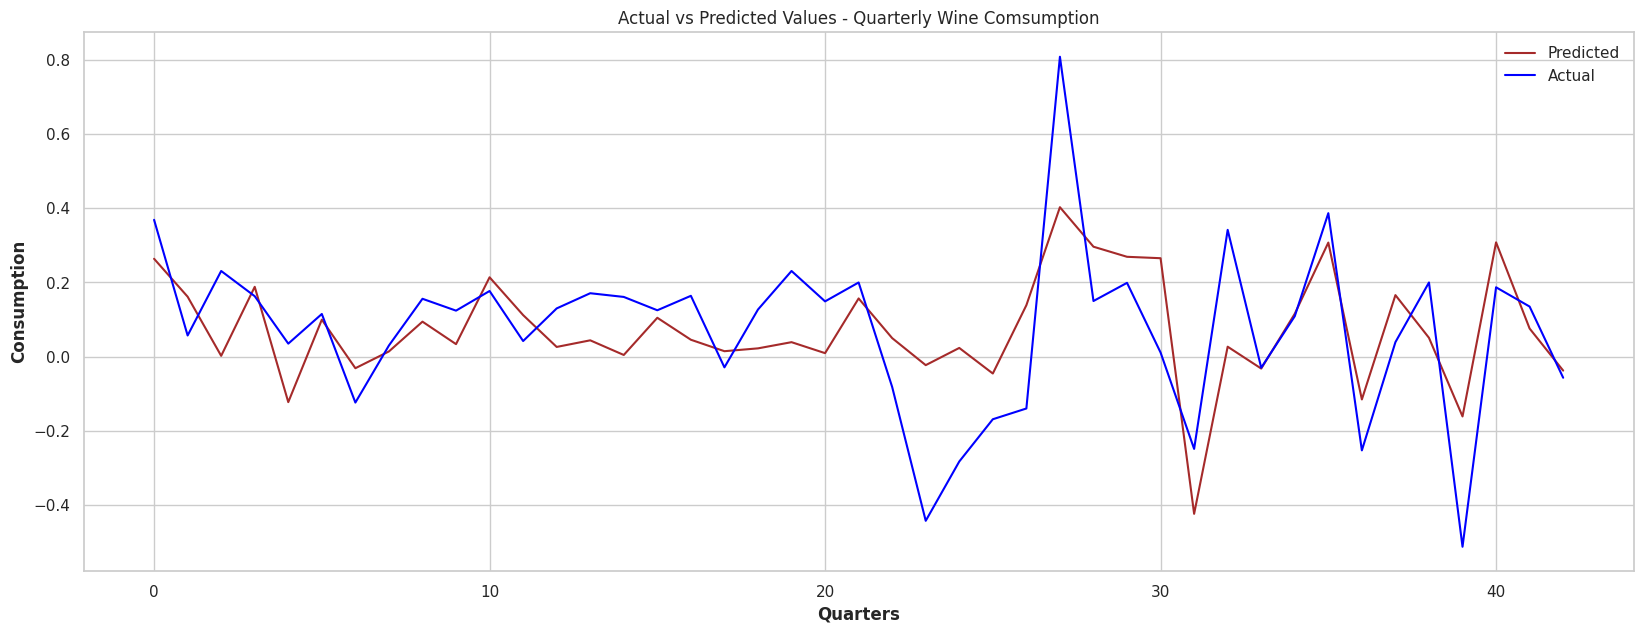

In [124]:
plt.figure(figsize=(20,7))
sns.set_theme(style="whitegrid")
sns.lineplot(predictions_ar_4, color = 'brown', label = "Predicted")
sns.lineplot(actual_values_post_lag_drop , color = 'blue', label = "Actual")

plt.title('Actual vs Predicted Values - Quarterly Wine Comsumption')
plt.ylabel("Consumption")
plt.xlabel("Quarters")
plt.legend()
plt.show()

# END